In [ ]:
## Notebook env: brian_script_env (R kernel)

In [ ]:
## two strategies
## q10/q90 analysis for median transcriptome CV (ie boxplot of q10 vs q90 with median transcriptome CV in each boxplot)
## can also do above analysis subset by breast cancer subtype
## alternate: do above but in PCA space with internal distance metric

In [1]:
library(Seurat)
library(ggplot2)
library(tidyverse)
library(ggforce)
library(ggpubr)

Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
## load the data
bc_atlas = Read10X(data.dir = '/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/Xu_et_al_2024_tumor_atlas/')
bc_atlas = CreateSeuratObject(counts = bc_atlas, project = 'Xu_et_al_2024_tumor_atlas', min.cells = 3, min.features = 200)

## add metadata
meta = read.csv('/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/Xu_et_al_2024_tumor_atlas/metadata.csv', row.names = 1)
meta = meta[rownames(bc_atlas@meta.data),] ## reorder rows to match bc_atlas
bc_atlas@meta.data = cbind(bc_atlas@meta.data, meta[,-c(1,2)])
final_meta = bc_atlas@meta.data

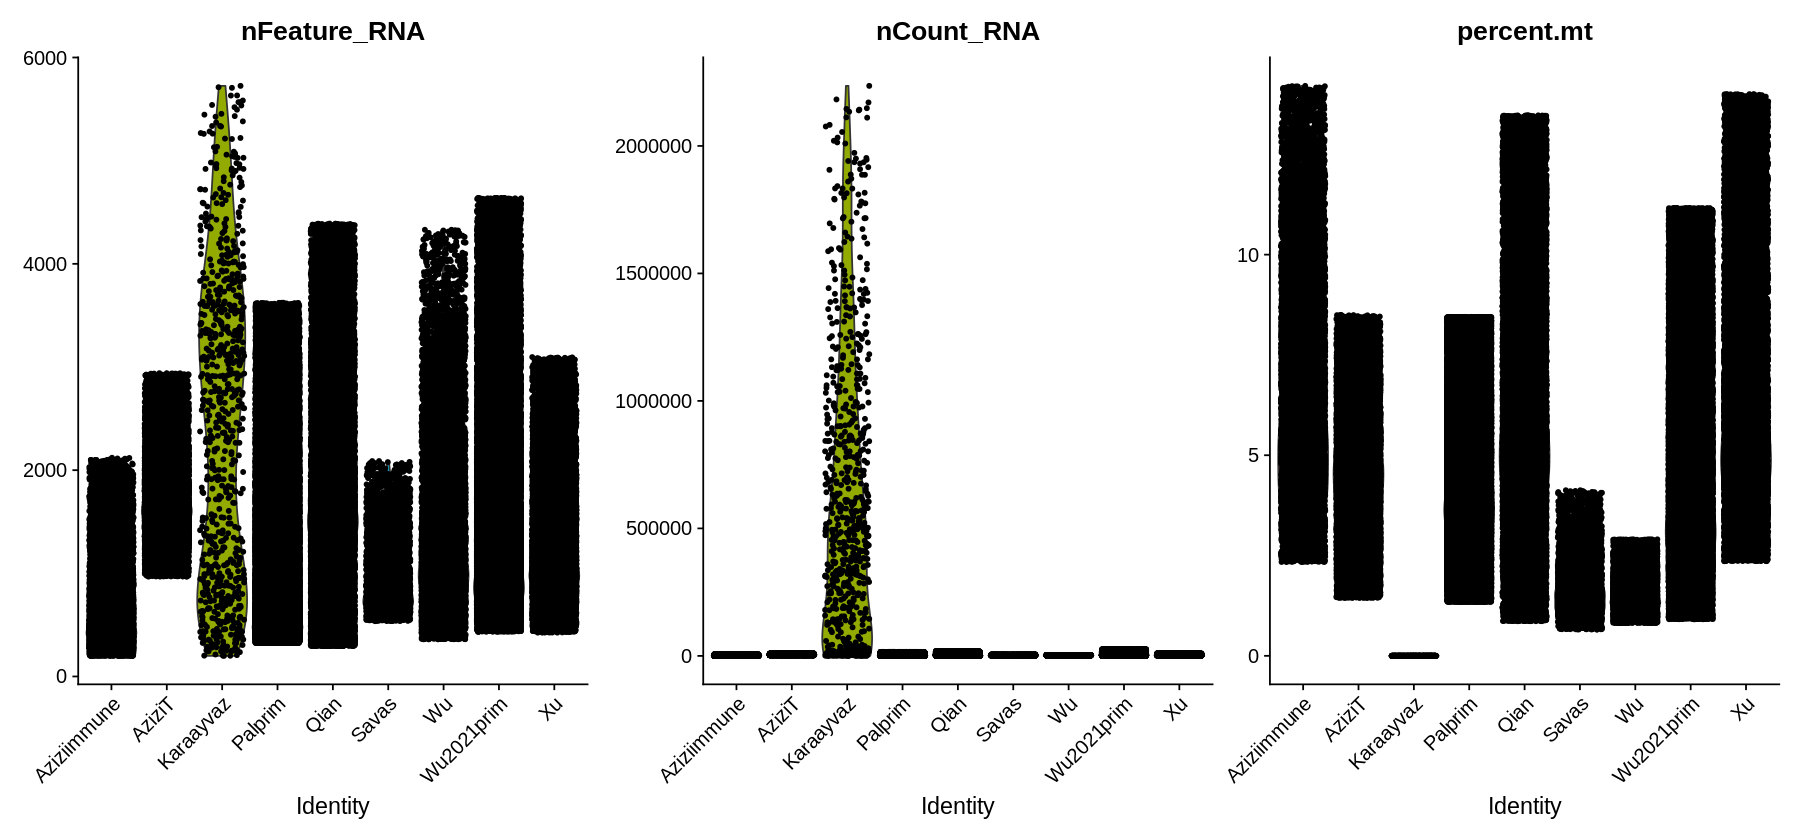

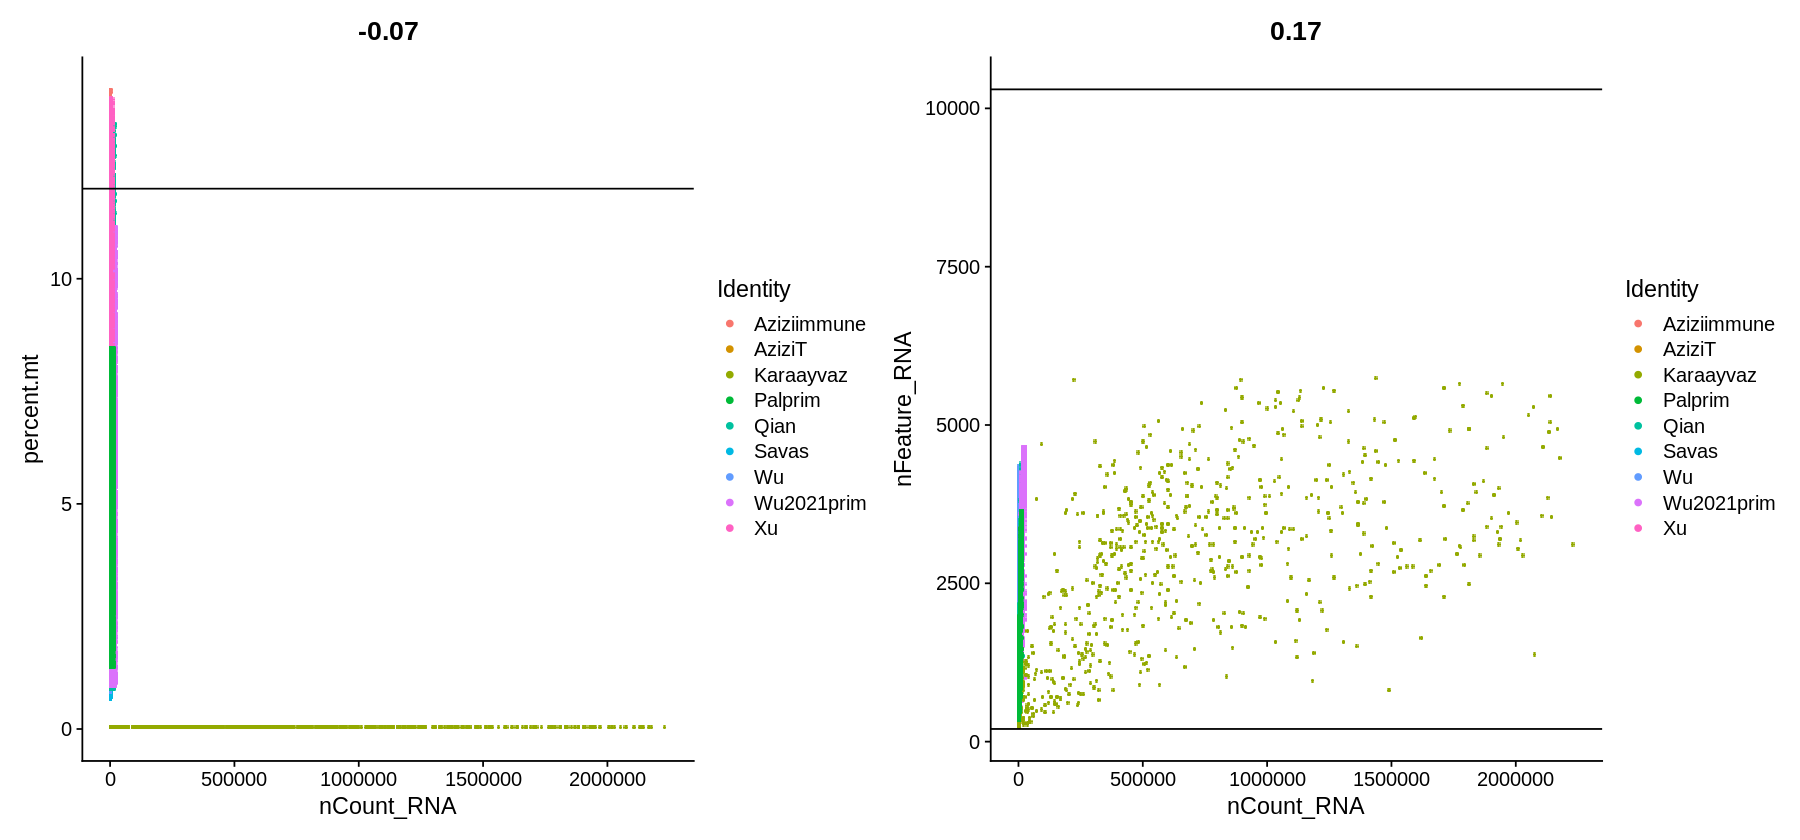

In [ ]:
options(repr.plot.width=15, repr.plot.height=7)
bc_atlas[["percent.mt"]] <- PercentageFeatureSet(bc_atlas, pattern = "^MT-")
VlnPlot(bc_atlas, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(bc_atlas, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_hline(yintercept = 12)
plot2 <- FeatureScatter(bc_atlas, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_hline(yintercept = 200) + geom_hline(yintercept = 10300)
plot1 + plot2

In [4]:
## patiens per dataset
## patient number doesn't matter because we will be mixing cells from different patients based on if they express top quantile of RNF8/MIS18A or bottom
## what matters is to do this analysis on a per dataset basis since different sequencing technologies used for each
final_meta %>% group_by(Dataset, Patient_ID) %>% count() %>% as.data.frame() %>% pull(Dataset) %>% table() %>% as.data.frame() %>% `colnames<-`(c('Dataset', 'Patients'))

Dataset,Patients
<fct>,<int>
Aziziimmune,8
AziziT,4
Karaayvaz,5
Pal_Prim,27
Qian,13
Savas,2
Wu,4
Wu2021prim,20
Xu,5


In [5]:
### these three use different 10x kits (many datasets in the atlas don't use 10x)
Pal_Prim_seurat = subset(x = bc_atlas, subset = Dataset == 'Pal_Prim')
Qian_seurat = subset(x = bc_atlas, subset = Dataset == 'Qian')
Wu2021_seurat = subset(x = bc_atlas, subset = Dataset == 'Wu2021prim')

## normalize
Pal_Prim_seurat <- NormalizeData(Pal_Prim_seurat, normalization.method = 'RC')
Qian_seurat <- NormalizeData(Qian_seurat, normalization.method = 'RC')
Wu2021_seurat <- NormalizeData(Wu2021_seurat, normalization.method = 'RC')

[1] "Pal_Prim 311 genes w/normalized median >= 0.1"

[1] "Qian 428 genes w/normalized median >= 0.1"

[1] "Wu2021 431 genes w/normalized median >= 0.1"

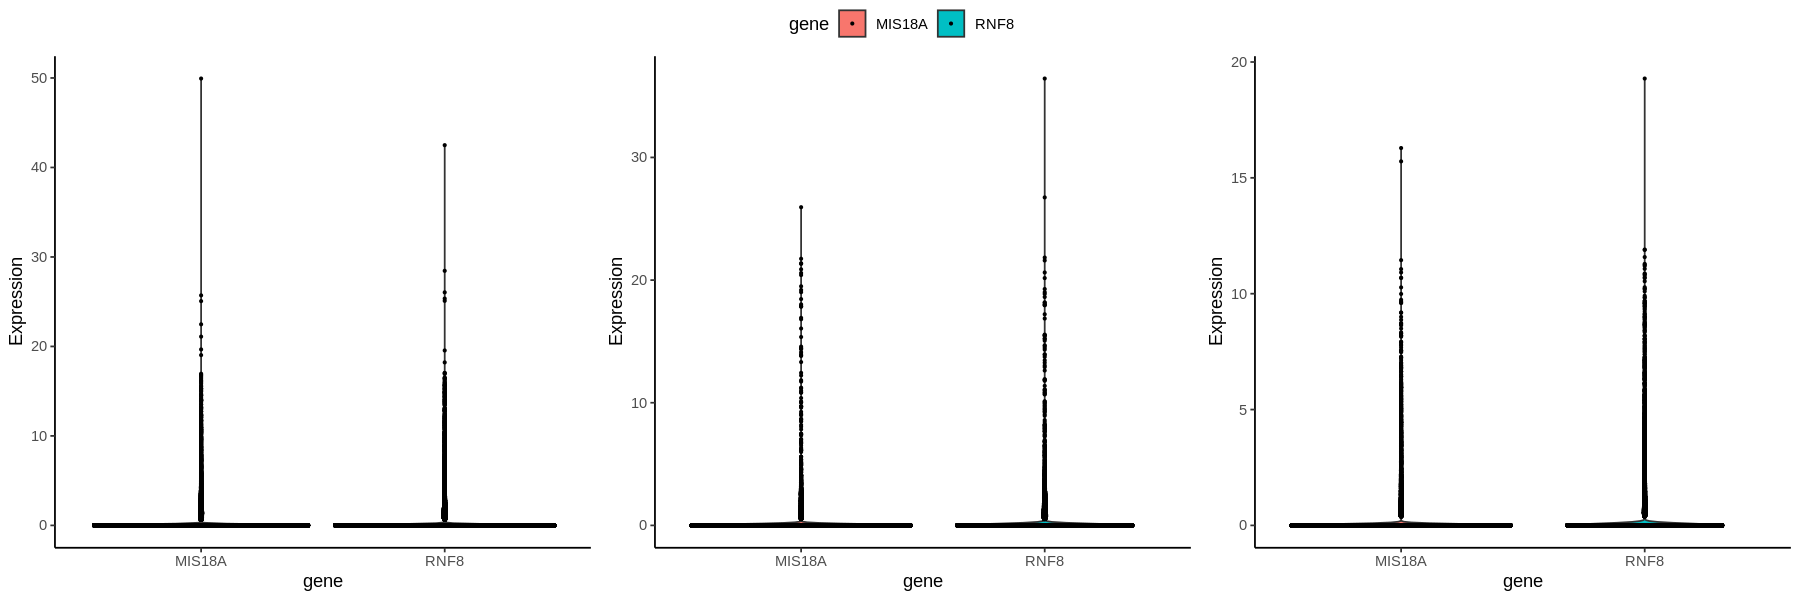

In [6]:
options(repr.plot.width = 15, repr.plot.height = 5)
filtered_raw_mtx <- Pal_Prim_seurat@assays$RNA@data
medians_Pal_Prim = sparseMatrixStats::rowMedians(filtered_raw_mtx)
paste('Pal_Prim', sum(medians_Pal_Prim >= 0.1), 'genes w/normalized median >= 0.1')

df_Pal_Prim = data.frame(gene = c(rep('RNF8', length(filtered_raw_mtx['RNF8',])), rep('MIS18A', length(filtered_raw_mtx['MIS18A',]))), exp = c(filtered_raw_mtx['RNF8',], filtered_raw_mtx['MIS18A',]))
pal_prim_plot = ggplot(df_Pal_Prim, aes(gene, exp, fill = gene)) + ylab('Expression') +
  geom_violin(position=position_dodge()) +
  geom_sina(position=position_dodge(), size = 0.5) + theme_classic() 

filtered_raw_mtx <- Qian_seurat@assays$RNA@data
medians_Qian = sparseMatrixStats::rowMedians(filtered_raw_mtx)
paste('Qian', sum(medians_Qian >= 0.1), 'genes w/normalized median >= 0.1')

df_Qian = data.frame(gene = c(rep('RNF8', length(filtered_raw_mtx['RNF8',])), rep('MIS18A', length(filtered_raw_mtx['MIS18A',]))), exp = c(filtered_raw_mtx['RNF8',], filtered_raw_mtx['MIS18A',]))
Qian_plot = ggplot(df_Qian, aes(gene, exp, fill = gene)) + ylab('Expression') +
  geom_violin(position=position_dodge()) +
  geom_sina(position=position_dodge(), size = 0.5) + theme_classic() 

filtered_raw_mtx <- Wu2021_seurat@assays$RNA@data
medians_Wu2021 = sparseMatrixStats::rowMedians(filtered_raw_mtx)
paste('Wu2021', sum(medians_Wu2021 >= 0.1), 'genes w/normalized median >= 0.1')

df_Wu2021 = data.frame(gene = c(rep('RNF8', length(filtered_raw_mtx['RNF8',])), rep('MIS18A', length(filtered_raw_mtx['MIS18A',]))), exp = c(filtered_raw_mtx['RNF8',], filtered_raw_mtx['MIS18A',]))
Wu2021_plot = ggplot(df_Wu2021, aes(gene, exp, fill = gene)) + ylab('Expression') +
  geom_violin(position=position_dodge()) +
  geom_sina(position=position_dodge(), size = 0.5) + theme_classic()

ggarrange(pal_prim_plot, Qian_plot, Wu2021_plot, ncol = 3, common.legend = TRUE)

### Single cell level stratification of overexp/underexp RNF8/MIS18A groups ###

In [7]:
print('Pal_Prim')
df_Pal_Prim %>% filter(gene == 'RNF8') %>% summarize(percentile = 100*(1-(sum(exp > 0)/length(exp)))) %>% pull(percentile) %>% paste('% RNF8 "overexpressed" cells above 0')
df_Pal_Prim %>% filter(gene == 'RNF8') %>% summarize(overexp_cell_count = sum(exp > 0)) %>% pull(overexp_cell_count) %>% paste('"overexpressed" RNF8 cells')

df_Pal_Prim %>% filter(gene == 'MIS18A') %>% summarize(percentile = 100*(1-(sum(exp > 0)/length(exp)))) %>% pull(percentile) %>% paste('% MIS18A "overexpressed" cells above 0')
df_Pal_Prim %>% filter(gene == 'MIS18A') %>% summarize(overexp_cell_count = sum(exp > 0)) %>% pull(overexp_cell_count) %>% paste('"overexpressed" MIS18A cells')

print('Qian')
df_Qian %>% filter(gene == 'RNF8') %>% summarize(percentile = 100*(1-(sum(exp > 0)/length(exp)))) %>% pull(percentile) %>% paste('% RNF8 "overexpressed" cells above 0')
df_Qian %>% filter(gene == 'RNF8') %>% summarize(overexp_cell_count = sum(exp > 0)) %>% pull(overexp_cell_count) %>% paste('"overexpressed" RNF8 cells')

df_Qian %>% filter(gene == 'MIS18A') %>% summarize(percentile = 100*(1-(sum(exp > 0)/length(exp)))) %>% pull(percentile) %>% paste('% MIS18A "overexpressed" cells above 0')
df_Qian %>% filter(gene == 'MIS18A') %>% summarize(overexp_cell_count = sum(exp > 0)) %>% pull(overexp_cell_count) %>% paste('"overexpressed" MIS18A cells')

print('Wu2021')
df_Wu2021 %>% filter(gene == 'RNF8') %>% summarize(percentile = 100*(1-(sum(exp > 0)/length(exp)))) %>% pull(percentile) %>% paste('% RNF8 "overexpressed" cells above 0')
df_Wu2021 %>% filter(gene == 'RNF8') %>% summarize(overexp_cell_count = sum(exp > 0)) %>% pull(overexp_cell_count) %>% paste('"overexpressed" RNF8 cells')

df_Wu2021 %>% filter(gene == 'MIS18A') %>% summarize(percentile = 100*(1-(sum(exp > 0)/length(exp)))) %>% pull(percentile) %>% paste('% MIS18A "overexpressed" cells above 0')
df_Wu2021 %>% filter(gene == 'MIS18A') %>% summarize(overexp_cell_count = sum(exp > 0)) %>% pull(overexp_cell_count) %>% paste('"overexpressed" MIS18A cells')

[1] "Pal_Prim"


[1] "92.7048378076063 % RNF8 \"overexpressed\" cells above 0"

[1] "6261 \"overexpressed\" RNF8 cells"

[1] "93.011278896346 % MIS18A \"overexpressed\" cells above 0"

[1] "5998 \"overexpressed\" MIS18A cells"

[1] "Qian"


[1] "91.7412775524953 % RNF8 \"overexpressed\" cells above 0"

[1] "2057 \"overexpressed\" RNF8 cells"

[1] "95.0295097763681 % MIS18A \"overexpressed\" cells above 0"

[1] "1238 \"overexpressed\" MIS18A cells"

[1] "Wu2021"


[1] "92.0042309801771 % RNF8 \"overexpressed\" cells above 0"

[1] "4082 \"overexpressed\" RNF8 cells"

[1] "94.9874637624383 % MIS18A \"overexpressed\" cells above 0"

[1] "2559 \"overexpressed\" MIS18A cells"

In [8]:
## conclusion from above nb cell: use 96th perentile and above for thresholding overexpressed cells, sample equal number of cells from underexpressed cells (0 expression) 
### find # cells in 96th percentile and above just to make sure it's a reasonable amount
print('Pal_Prim')
df_Pal_Prim %>% filter(gene == 'RNF8') %>% summarize(overexp_cell_count = sum(exp >= quantile(exp, 0.96))) %>% pull(overexp_cell_count) %>% paste('"overexpressed" RNF8 cells')
df_Pal_Prim %>% filter(gene == 'MIS18A') %>% summarize(overexp_cell_count = sum(exp >= quantile(exp, 0.96))) %>% pull(overexp_cell_count) %>% paste('"overexpressed" MIS18A cells')

print('Qian')
df_Qian %>% filter(gene == 'RNF8') %>% summarize(overexp_cell_count = sum(exp >= quantile(exp, 0.96))) %>% pull(overexp_cell_count) %>% paste('"overexpressed" RNF8 cells')
df_Qian %>% filter(gene == 'MIS18A') %>% summarize(overexp_cell_count = sum(exp >= quantile(exp, 0.96))) %>% pull(overexp_cell_count) %>% paste('"overexpressed" MIS18A cells')

print('Wu2021')
df_Wu2021 %>% filter(gene == 'RNF8') %>% summarize(overexp_cell_count = sum(exp >= quantile(exp, 0.96))) %>% pull(overexp_cell_count) %>% paste('"overexpressed" RNF8 cells')
df_Wu2021 %>% filter(gene == 'MIS18A') %>% summarize(overexp_cell_count = sum(exp >= quantile(exp, 0.96))) %>% pull(overexp_cell_count) %>% paste('"overexpressed" MIS18A cells')

[1] "Pal_Prim"


[1] "3433 \"overexpressed\" RNF8 cells"

[1] "3433 \"overexpressed\" MIS18A cells"

[1] "Qian"


[1] "998 \"overexpressed\" RNF8 cells"

[1] "997 \"overexpressed\" MIS18A cells"

[1] "Wu2021"


[1] "2043 \"overexpressed\" RNF8 cells"

[1] "2043 \"overexpressed\" MIS18A cells"

In [9]:
## conclusion use 3433 cells for Pal_Prim, 997 cells for Qian, 2043 cells for Wu2021
## only keep genes with median expression >= 0.1

set.seed(123)
## RNF8

Pal_Prim_RNF8_up = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@assays$RNA@data['RNF8',] >= quantile(Pal_Prim_seurat@assays$RNA@data['RNF8',], 0.96))]
Pal_Prim_RNF8_down = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, sample(which(Pal_Prim_seurat@assays$RNA@data['RNF8',] == 0), ncol(Pal_Prim_RNF8_up))]

Qian_RNF8_up = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, sample(which(Qian_seurat@assays$RNA@data['RNF8',] >= quantile(Qian_seurat@assays$RNA@data['RNF8',], 0.96)), 997)]
Qian_RNF8_down = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, sample(which(Qian_seurat@assays$RNA@data['RNF8',] == 0), ncol(Qian_RNF8_up))]

Wu2021_RNF8_up = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@assays$RNA@data['RNF8',] >= quantile(Wu2021_seurat@assays$RNA@data['RNF8',], 0.96))]
Wu2021_RNF8_down = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, sample(which(Wu2021_seurat@assays$RNA@data['RNF8',] == 0), ncol(Wu2021_RNF8_up))]

## MIS18A
Pal_Prim_MIS18A_up = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@assays$RNA@data['MIS18A',] >= quantile(Pal_Prim_seurat@assays$RNA@data['MIS18A',], 0.96))]
Pal_Prim_MIS18A_down = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, sample(which(Pal_Prim_seurat@assays$RNA@data['MIS18A',] == 0), ncol(Pal_Prim_MIS18A_up))]

Qian_MIS18A_up = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@assays$RNA@data['MIS18A',] >= quantile(Qian_seurat@assays$RNA@data['MIS18A',], 0.96))]
Qian_MIS18A_down = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, sample(which(Qian_seurat@assays$RNA@data['MIS18A',] == 0), ncol(Qian_MIS18A_up))]

Wu2021_MIS18A_up = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@assays$RNA@data['MIS18A',] >= quantile(Wu2021_seurat@assays$RNA@data['MIS18A',], 0.96))]
Wu2021_MIS18A_down = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, sample(which(Wu2021_seurat@assays$RNA@data['MIS18A',] == 0), ncol(Wu2021_MIS18A_up))]

## combine
RN8_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_RNF8_down, 'overexp' = Pal_Prim_RNF8_up), 'Qian' = list('underexp' = Qian_RNF8_down, 'overexp' = Qian_RNF8_up), 'Wu2021' = list('underexp' = Wu2021_RNF8_down, 'overexp' = Wu2021_RNF8_up))
MIS18A_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_MIS18A_down, 'overexp' = Pal_Prim_MIS18A_up), 'Qian' = list('underexp' = Qian_MIS18A_down, 'overexp' = Qian_MIS18A_up), 'Wu2021' = list('underexp' = Wu2021_MIS18A_down, 'overexp' = Wu2021_MIS18A_up))

## calculate CVs for each gene in each dataset
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs_RNF8 = lapply(RN8_datasets, function(x) lapply(x, CV_calculator))
CVs_MIS18A = lapply(MIS18A_datasets, function(x) lapply(x, CV_calculator))

## calculate overexpressed vs underexpressed ratio
CV_ratios_RNF8 = lapply(CVs_RNF8, function(x) x$overexp/x$underexp)
CV_ratios_MIS18A = lapply(CVs_MIS18A, function(x) x$overexp/x$underexp)

df_RNF8 = data.frame(unlist(CV_ratios_RNF8, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'RNF8') %>% remove_rownames()
df_MIS18A = data.frame(unlist(CV_ratios_MIS18A, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'MIS18A') %>% remove_rownames()
df = rbind(df_RNF8, df_MIS18A)

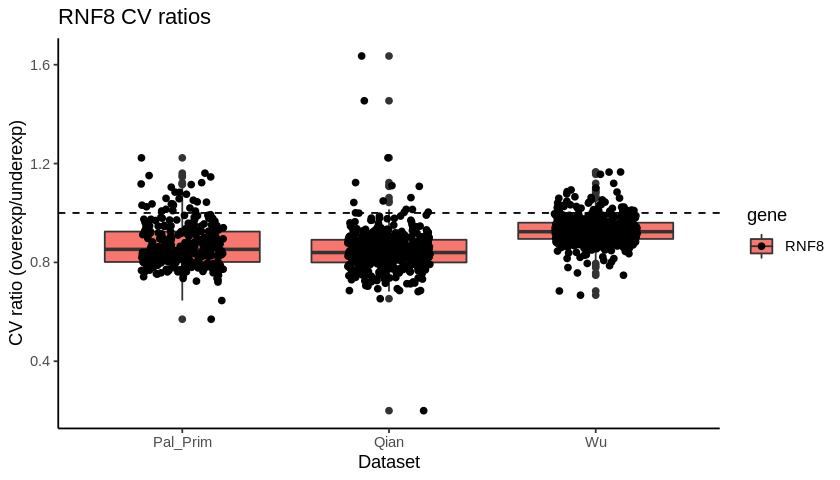

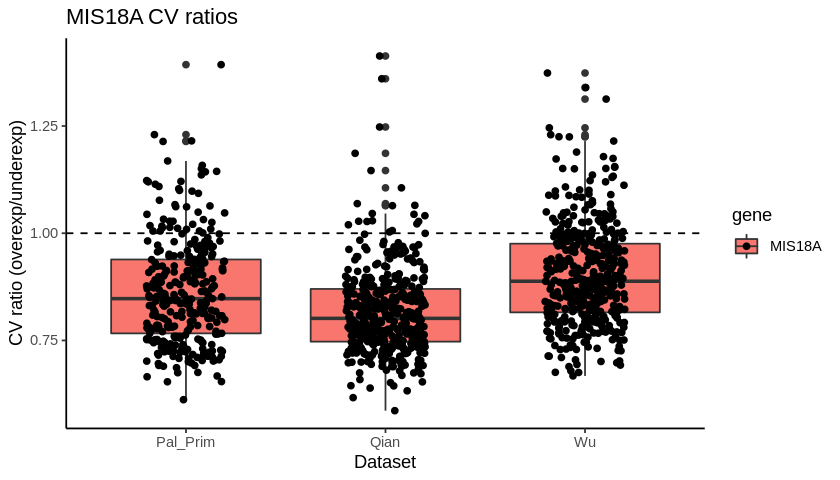

In [10]:
## lets plot the CV ratios
options(repr.plot.width = 7, repr.plot.height = 4)
df %>% filter(gene == 'RNF8') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('RNF8 CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')
df %>% filter(gene == 'MIS18A') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('MIS18A CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')

### Patient level stratification of overexp/underexp RNF8/MIS18A groups ###

In [22]:
## create sample quantiles for each CO per sample per dataset ##
Pal_Prim_CO_exp = data.frame(RNF8 = Pal_Prim_seurat@assays$RNA@data['RNF8',], MIS18A = Pal_Prim_seurat@assays$RNA@data['MIS18A',], Sample = Pal_Prim_seurat@meta.data$Sample)
Pal_Prim_CO_sample_quantiles = Pal_Prim_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .1)) ~ 'q10', if_all(mean_exp, function(x) x >= quantile(x, .9)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

Qian_CO_exp = data.frame(RNF8 = Qian_seurat@assays$RNA@data['RNF8',], MIS18A = Qian_seurat@assays$RNA@data['MIS18A',], Sample = Qian_seurat@meta.data$Sample)
Qian_CO_sample_quantiles = Qian_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .1)) ~ 'q10', if_all(mean_exp, function(x) x >= quantile(x, .9)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

Wu2021_CO_exp = data.frame(RNF8 = Wu2021_seurat@assays$RNA@data['RNF8',], MIS18A = Wu2021_seurat@assays$RNA@data['MIS18A',], Sample = Wu2021_seurat@meta.data$Sample)
Wu2021_CO_sample_quantiles = Wu2021_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .1)) ~ 'q10', if_all(mean_exp, function(x) x >= quantile(x, .9)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

## only keep genes with median expression >= 0.1 ##

## RNF8
Pal_Prim_RNF8_up = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q90') %>% pull(Sample)))]
Pal_Prim_RNF8_down = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q10') %>% pull(Sample)))]

Qian_RNF8_up = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q90') %>% pull(Sample)))]
Qian_RNF8_down = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q10') %>% pull(Sample)))]

Wu2021_RNF8_up = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q90') %>% pull(Sample)))]
Wu2021_RNF8_down = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q10') %>% pull(Sample)))]

## MIS18A
Pal_Prim_MIS18A_up = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q90') %>% pull(Sample)))]
Pal_Prim_MIS18A_down = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q10') %>% pull(Sample)))]

Qian_MIS18A_up = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q90') %>% pull(Sample)))]
Qian_MIS18A_down = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q10') %>% pull(Sample)))]

Wu2021_MIS18A_up = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q90') %>% pull(Sample)))]
Wu2021_MIS18A_down = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q10') %>% pull(Sample)))]

## combine
RN8_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_RNF8_down, 'overexp' = Pal_Prim_RNF8_up), 'Qian' = list('underexp' = Qian_RNF8_down, 'overexp' = Qian_RNF8_up), 'Wu2021' = list('underexp' = Wu2021_RNF8_down, 'overexp' = Wu2021_RNF8_up))
MIS18A_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_MIS18A_down, 'overexp' = Pal_Prim_MIS18A_up), 'Qian' = list('underexp' = Qian_MIS18A_down, 'overexp' = Qian_MIS18A_up), 'Wu2021' = list('underexp' = Wu2021_MIS18A_down, 'overexp' = Wu2021_MIS18A_up))


## calculate CVs for each gene in each dataset
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs_RNF8 = lapply(RN8_datasets, function(x) lapply(x, CV_calculator))
CVs_MIS18A = lapply(MIS18A_datasets, function(x) lapply(x, CV_calculator))

## calculate overexpressed vs underexpressed ratio
CV_ratios_RNF8 = lapply(CVs_RNF8, function(x) x$overexp/x$underexp)
CV_ratios_MIS18A = lapply(CVs_MIS18A, function(x) x$overexp/x$underexp)

df_RNF8 = data.frame(unlist(CV_ratios_RNF8, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'RNF8') %>% remove_rownames()
df_MIS18A = data.frame(unlist(CV_ratios_MIS18A, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'MIS18A') %>% remove_rownames()
df = rbind(df_RNF8, df_MIS18A)

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.



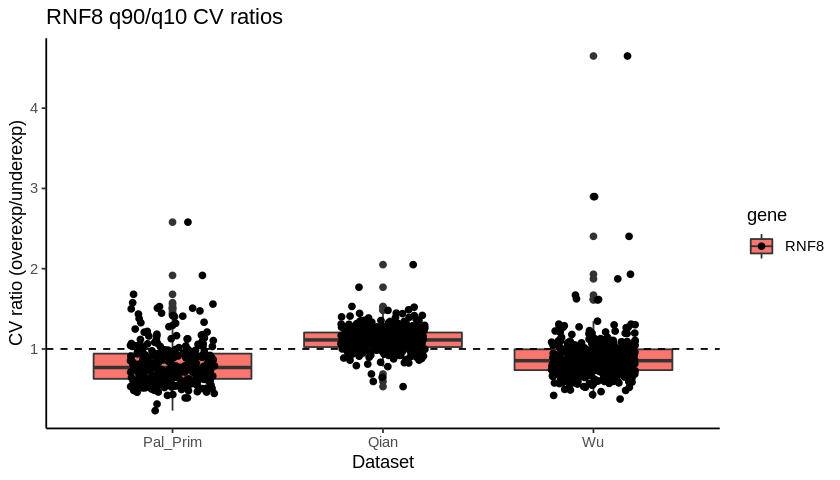

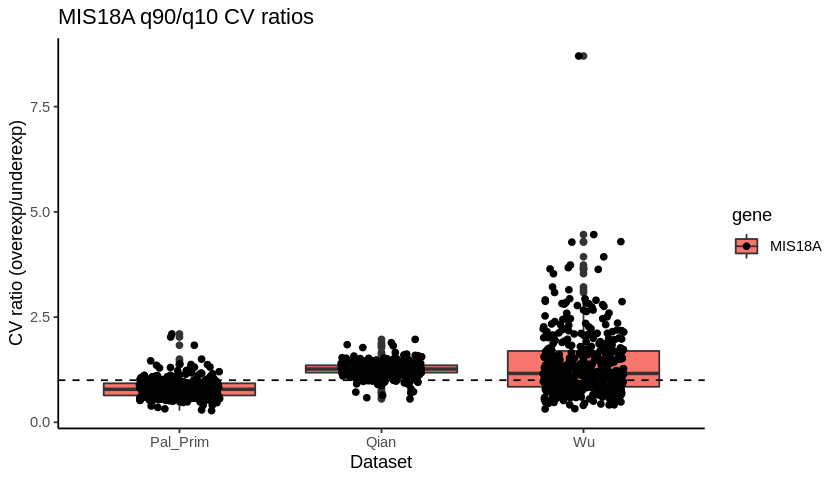

In [12]:
## lets plot the CV ratios
options(repr.plot.width = 7, repr.plot.height = 4)
df %>% filter(gene == 'RNF8') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('RNF8 q90/q10 CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')
df %>% filter(gene == 'MIS18A') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('MIS18A q90/q10 CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')

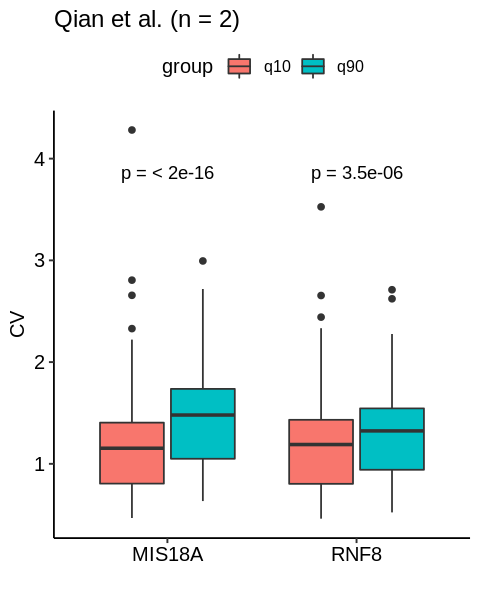

In [24]:
CVs_RNF8_df = unlist(CVs_RNF8['Qian'], use.names = TRUE) %>% as.data.frame() %>% `colnames<-`('CV') %>% mutate(group = rownames(.)) %>% mutate(group = stringr::str_replace_all(group, "[:digit:]", "")) %>% separate(col = group, into = c('Dataset' , 'group')) %>% mutate(gene = 'RNF8')
CVs_MIS18A_df = unlist(CVs_MIS18A['Qian'], use.names = TRUE) %>% as.data.frame() %>% `colnames<-`('CV') %>% mutate(group = rownames(.)) %>% mutate(group = stringr::str_replace_all(group, "[:digit:]", "")) %>% separate(col = group, into = c('Dataset' , 'group')) %>% mutate(gene = 'MIS18A')
CVs_df = rbind(CVs_RNF8_df, CVs_MIS18A_df) %>% mutate(group = plyr::mapvalues(group, from = c('underexp', 'overexp'), to = c('q10', 'q90'))) %>% mutate(group = factor(group, levels = c('q10', 'q90')))

# fig_path = '/khayyam/ssobti/projects/heterogeneity_brian/'
# saveRDS(CVs_df, paste0(fig_path, 'fig_output/data/fig3/qian_CVs_df_q10_q90.rds'))

## only kept genes with median normalized expression >= 0.1 ##
options(repr.plot.width = 4, repr.plot.height = 5)
ggplot(CVs_df, aes(x = gene, y = CV, fill = group)) + geom_boxplot() + theme_pubr() + xlab('') + ggtitle('Qian et al. (n = 2)') + stat_compare_means(method = 'wilcox.test', label.y = 3.8, aes(label = paste0("p = ", after_stat(p.format))))

In [25]:
## q75/q25 analysis ##
## create sample quantiles for each CO per sample per dataset ##
Pal_Prim_CO_exp = data.frame(RNF8 = Pal_Prim_seurat@assays$RNA@data['RNF8',], MIS18A = Pal_Prim_seurat@assays$RNA@data['MIS18A',], Sample = Pal_Prim_seurat@meta.data$Sample)
Pal_Prim_CO_sample_quantiles = Pal_Prim_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(mean_exp, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

Qian_CO_exp = data.frame(RNF8 = Qian_seurat@assays$RNA@data['RNF8',], MIS18A = Qian_seurat@assays$RNA@data['MIS18A',], Sample = Qian_seurat@meta.data$Sample)
Qian_CO_sample_quantiles = Qian_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(mean_exp, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

Wu2021_CO_exp = data.frame(RNF8 = Wu2021_seurat@assays$RNA@data['RNF8',], MIS18A = Wu2021_seurat@assays$RNA@data['MIS18A',], Sample = Wu2021_seurat@meta.data$Sample)
Wu2021_CO_sample_quantiles = Wu2021_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(mean_exp, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

## only keep genes with median expression >= 0.1 ##

## RNF8
Pal_Prim_RNF8_up = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q75') %>% pull(Sample)))]
Pal_Prim_RNF8_down = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q25') %>% pull(Sample)))]

Qian_RNF8_up = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q75') %>% pull(Sample)))]
Qian_RNF8_down = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q25') %>% pull(Sample)))]

Wu2021_RNF8_up = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q75') %>% pull(Sample)))]
Wu2021_RNF8_down = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q25') %>% pull(Sample)))]

## MIS18A
Pal_Prim_MIS18A_up = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q75') %>% pull(Sample)))]
Pal_Prim_MIS18A_down = Pal_Prim_seurat@assays$RNA@data[medians_Pal_Prim >= 0.1, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q25') %>% pull(Sample)))]

Qian_MIS18A_up = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q75') %>% pull(Sample)))]
Qian_MIS18A_down = Qian_seurat@assays$RNA@data[medians_Qian >= 0.1, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q25') %>% pull(Sample)))]

Wu2021_MIS18A_up = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q75') %>% pull(Sample)))]
Wu2021_MIS18A_down = Wu2021_seurat@assays$RNA@data[medians_Wu2021 >= 0.1, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q25') %>% pull(Sample)))]

## combine
RN8_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_RNF8_down, 'overexp' = Pal_Prim_RNF8_up), 'Qian' = list('underexp' = Qian_RNF8_down, 'overexp' = Qian_RNF8_up), 'Wu2021' = list('underexp' = Wu2021_RNF8_down, 'overexp' = Wu2021_RNF8_up))
MIS18A_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_MIS18A_down, 'overexp' = Pal_Prim_MIS18A_up), 'Qian' = list('underexp' = Qian_MIS18A_down, 'overexp' = Qian_MIS18A_up), 'Wu2021' = list('underexp' = Wu2021_MIS18A_down, 'overexp' = Wu2021_MIS18A_up))


## calculate CVs for each gene in each dataset
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs_RNF8 = lapply(RN8_datasets, function(x) lapply(x, CV_calculator))
CVs_MIS18A = lapply(MIS18A_datasets, function(x) lapply(x, CV_calculator))

## calculate overexpressed vs underexpressed ratio
CV_ratios_RNF8 = lapply(CVs_RNF8, function(x) x$overexp/x$underexp)
CV_ratios_MIS18A = lapply(CVs_MIS18A, function(x) x$overexp/x$underexp)

df_RNF8 = data.frame(unlist(CV_ratios_RNF8, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'RNF8') %>% remove_rownames()
df_MIS18A = data.frame(unlist(CV_ratios_MIS18A, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'MIS18A') %>% remove_rownames()
df = rbind(df_RNF8, df_MIS18A)

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.



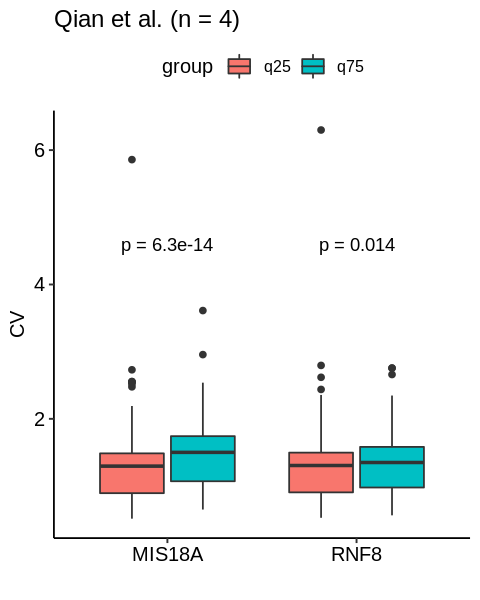

In [26]:
CVs_RNF8_df = unlist(CVs_RNF8['Qian'], use.names = TRUE) %>% as.data.frame() %>% `colnames<-`('CV') %>% mutate(group = rownames(.)) %>% mutate(group = stringr::str_replace_all(group, "[:digit:]", "")) %>% separate(col = group, into = c('Dataset' , 'group')) %>% mutate(gene = 'RNF8')
CVs_MIS18A_df = unlist(CVs_MIS18A['Qian'], use.names = TRUE) %>% as.data.frame() %>% `colnames<-`('CV') %>% mutate(group = rownames(.)) %>% mutate(group = stringr::str_replace_all(group, "[:digit:]", "")) %>% separate(col = group, into = c('Dataset' , 'group')) %>% mutate(gene = 'MIS18A')
CVs_df = rbind(CVs_RNF8_df, CVs_MIS18A_df) %>% mutate(group = plyr::mapvalues(group, from = c('underexp', 'overexp'), to = c('q25', 'q75'))) %>% mutate(group = factor(group, levels = c('q25', 'q75')))

# fig_path = '/khayyam/ssobti/projects/heterogeneity_brian/'
# saveRDS(CVs_df, paste0(fig_path, 'fig_output/data/fig3/qian_CVs_df_q25_q75.rds'))

## only kept genes with median normalized expression >= 0.1 ##
options(repr.plot.width = 4, repr.plot.height = 5)
ggplot(CVs_df, aes(x = gene, y = CV, fill = group)) + geom_boxplot() + theme_pubr() + xlab('') + ggtitle('Qian et al. (n = 4)') + stat_compare_means(method = 'wilcox.test', label.y = 4.5, aes(label = paste0("p = ", after_stat(p.format))))

### Single cell level stratification of overexp/underexp RNF8/MIS18A groups ###
### (increase genes in each dataset to those with mean, instead of median, >= cutoff) ###

In [16]:
means_Pal_Prim = sparseMatrixStats::rowMeans2(Pal_Prim_seurat@assays$RNA@data)
means_Qian = sparseMatrixStats::rowMeans2(Qian_seurat@assays$RNA@data)
means_Wu2021 = sparseMatrixStats::rowMeans2(Wu2021_seurat@assays$RNA@data)

In [17]:
## conclusion use 3433 cells for Pal_Prim, 997 cells for Qian, 2043 cells for Wu2021
## only keep genes with median expression >= cutoff

set.seed(123)
## RNF8
cutoff = 0.5

Pal_Prim_RNF8_up = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, which(Pal_Prim_seurat@assays$RNA@data['RNF8',] >= quantile(Pal_Prim_seurat@assays$RNA@data['RNF8',], 0.96))]
Pal_Prim_RNF8_down = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, sample(which(Pal_Prim_seurat@assays$RNA@data['RNF8',] == 0), ncol(Pal_Prim_RNF8_up))]

Qian_RNF8_up = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, sample(which(Qian_seurat@assays$RNA@data['RNF8',] >= quantile(Qian_seurat@assays$RNA@data['RNF8',], 0.96)), 997)]
Qian_RNF8_down = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, sample(which(Qian_seurat@assays$RNA@data['RNF8',] == 0), ncol(Qian_RNF8_up))]

Wu2021_RNF8_up = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, which(Wu2021_seurat@assays$RNA@data['RNF8',] >= quantile(Wu2021_seurat@assays$RNA@data['RNF8',], 0.96))]
Wu2021_RNF8_down = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, sample(which(Wu2021_seurat@assays$RNA@data['RNF8',] == 0), ncol(Wu2021_RNF8_up))]

## MIS18A
Pal_Prim_MIS18A_up = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, which(Pal_Prim_seurat@assays$RNA@data['MIS18A',] >= quantile(Pal_Prim_seurat@assays$RNA@data['MIS18A',], 0.96))]
Pal_Prim_MIS18A_down = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, sample(which(Pal_Prim_seurat@assays$RNA@data['MIS18A',] == 0), ncol(Pal_Prim_MIS18A_up))]

Qian_MIS18A_up = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, which(Qian_seurat@assays$RNA@data['MIS18A',] >= quantile(Qian_seurat@assays$RNA@data['MIS18A',], 0.96))]
Qian_MIS18A_down = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, sample(which(Qian_seurat@assays$RNA@data['MIS18A',] == 0), ncol(Qian_MIS18A_up))]

Wu2021_MIS18A_up = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, which(Wu2021_seurat@assays$RNA@data['MIS18A',] >= quantile(Wu2021_seurat@assays$RNA@data['MIS18A',], 0.96))]
Wu2021_MIS18A_down = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, sample(which(Wu2021_seurat@assays$RNA@data['MIS18A',] == 0), ncol(Wu2021_MIS18A_up))]

## combine
RN8_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_RNF8_down, 'overexp' = Pal_Prim_RNF8_up), 'Qian' = list('underexp' = Qian_RNF8_down, 'overexp' = Qian_RNF8_up), 'Wu2021' = list('underexp' = Wu2021_RNF8_down, 'overexp' = Wu2021_RNF8_up))
MIS18A_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_MIS18A_down, 'overexp' = Pal_Prim_MIS18A_up), 'Qian' = list('underexp' = Qian_MIS18A_down, 'overexp' = Qian_MIS18A_up), 'Wu2021' = list('underexp' = Wu2021_MIS18A_down, 'overexp' = Wu2021_MIS18A_up))

## calculate CVs for each gene in each dataset
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs_RNF8 = lapply(RN8_datasets, function(x) lapply(x, CV_calculator))
CVs_MIS18A = lapply(MIS18A_datasets, function(x) lapply(x, CV_calculator))

## calculate overexpressed vs underexpressed ratio
CV_ratios_RNF8 = lapply(CVs_RNF8, function(x) x$overexp/x$underexp)
CV_ratios_MIS18A = lapply(CVs_MIS18A, function(x) x$overexp/x$underexp)

df_RNF8 = data.frame(unlist(CV_ratios_RNF8, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'RNF8') %>% remove_rownames()
df_MIS18A = data.frame(unlist(CV_ratios_MIS18A, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'MIS18A') %>% remove_rownames()
df = rbind(df_RNF8, df_MIS18A)

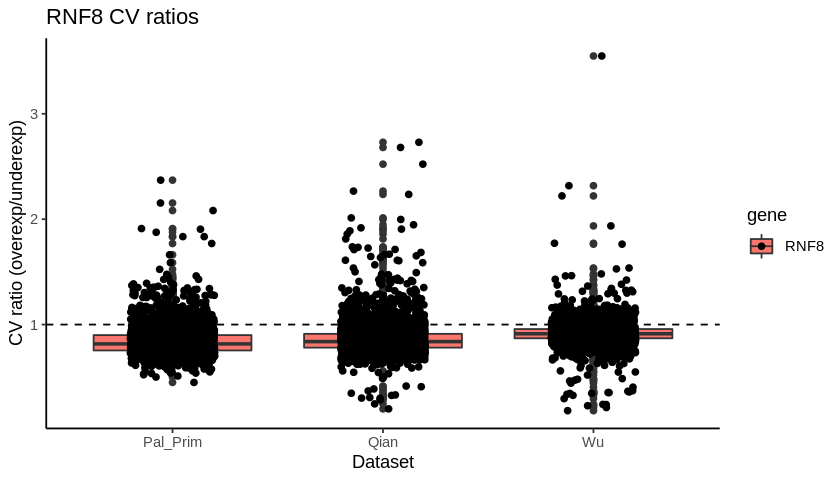

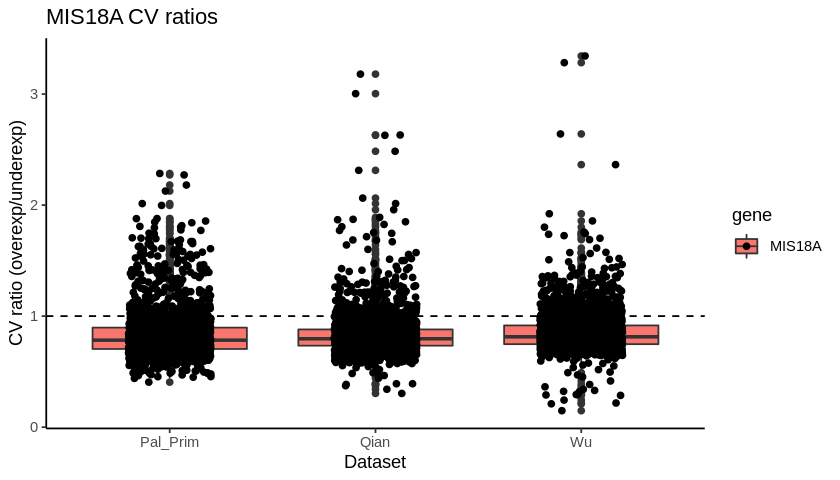

In [18]:
## lets plot the CV ratios
options(repr.plot.width = 7, repr.plot.height = 4)
df %>% filter(gene == 'RNF8') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('RNF8 CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')
df %>% filter(gene == 'MIS18A') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('MIS18A CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')

### Patient level stratification of overexp/underexp RNF8/MIS18A groups ###
### (increase genes in each dataset to those with mean, instead of median, >= cutoff) ###

In [19]:
## create sample quantiles for each CO per sample per dataset ##
Pal_Prim_CO_exp = data.frame(RNF8 = Pal_Prim_seurat@assays$RNA@data['RNF8',], MIS18A = Pal_Prim_seurat@assays$RNA@data['MIS18A',], Sample = Pal_Prim_seurat@meta.data$Sample)
Pal_Prim_CO_sample_quantiles = Pal_Prim_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .1)) ~ 'q10', if_all(mean_exp, function(x) x >= quantile(x, .9)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

Qian_CO_exp = data.frame(RNF8 = Qian_seurat@assays$RNA@data['RNF8',], MIS18A = Qian_seurat@assays$RNA@data['MIS18A',], Sample = Qian_seurat@meta.data$Sample)
Qian_CO_sample_quantiles = Qian_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .1)) ~ 'q10', if_all(mean_exp, function(x) x >= quantile(x, .9)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

Wu2021_CO_exp = data.frame(RNF8 = Wu2021_seurat@assays$RNA@data['RNF8',], MIS18A = Wu2021_seurat@assays$RNA@data['MIS18A',], Sample = Wu2021_seurat@meta.data$Sample)
Wu2021_CO_sample_quantiles = Wu2021_CO_exp %>% pivot_longer(cols = c('RNF8', 'MIS18A'), names_to = 'gene', values_to = 'exp') %>% group_by(gene, Sample) %>% summarize(mean_exp = mean(exp)) %>% group_by(gene) %>%
    mutate(quantile = case_when(if_all(mean_exp, function(x) x <= quantile(x, .1)) ~ 'q10', if_all(mean_exp, function(x) x >= quantile(x, .9)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

## only keep genes with median expression >= cutoff ##
cutoff = 1

## RNF8
Pal_Prim_RNF8_up = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q90') %>% pull(Sample)))]
Pal_Prim_RNF8_down = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q10') %>% pull(Sample)))]

Qian_RNF8_up = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q90') %>% pull(Sample)))]
Qian_RNF8_down = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q10') %>% pull(Sample)))]

Wu2021_RNF8_up = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q90') %>% pull(Sample)))]
Wu2021_RNF8_down = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'RNF8', quantile == 'q10') %>% pull(Sample)))]

## MIS18A
Pal_Prim_MIS18A_up = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q90') %>% pull(Sample)))]
Pal_Prim_MIS18A_down = Pal_Prim_seurat@assays$RNA@data[means_Pal_Prim >= cutoff, which(Pal_Prim_seurat@meta.data$Sample %in% (Pal_Prim_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q10') %>% pull(Sample)))]

Qian_MIS18A_up = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q90') %>% pull(Sample)))]
Qian_MIS18A_down = Qian_seurat@assays$RNA@data[means_Qian >= cutoff, which(Qian_seurat@meta.data$Sample %in% (Qian_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q10') %>% pull(Sample)))]

Wu2021_MIS18A_up = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q90') %>% pull(Sample)))]
Wu2021_MIS18A_down = Wu2021_seurat@assays$RNA@data[means_Wu2021 >= cutoff, which(Wu2021_seurat@meta.data$Sample %in% (Wu2021_CO_sample_quantiles %>% filter(gene == 'MIS18A', quantile == 'q10') %>% pull(Sample)))]

## combine
RN8_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_RNF8_down, 'overexp' = Pal_Prim_RNF8_up), 'Qian' = list('underexp' = Qian_RNF8_down, 'overexp' = Qian_RNF8_up), 'Wu2021' = list('underexp' = Wu2021_RNF8_down, 'overexp' = Wu2021_RNF8_up))
MIS18A_datasets = list('Pal_Prim' = list('underexp' = Pal_Prim_MIS18A_down, 'overexp' = Pal_Prim_MIS18A_up), 'Qian' = list('underexp' = Qian_MIS18A_down, 'overexp' = Qian_MIS18A_up), 'Wu2021' = list('underexp' = Wu2021_MIS18A_down, 'overexp' = Wu2021_MIS18A_up))


## calculate CVs for each gene in each dataset
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs_RNF8 = lapply(RN8_datasets, function(x) lapply(x, CV_calculator))
CVs_MIS18A = lapply(MIS18A_datasets, function(x) lapply(x, CV_calculator))

## calculate overexpressed vs underexpressed ratio
CV_ratios_RNF8 = lapply(CVs_RNF8, function(x) x$overexp/x$underexp)
CV_ratios_MIS18A = lapply(CVs_MIS18A, function(x) x$overexp/x$underexp)

df_RNF8 = data.frame(unlist(CV_ratios_RNF8, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'RNF8') %>% remove_rownames()
df_MIS18A = data.frame(unlist(CV_ratios_MIS18A, use.names = TRUE)) %>% mutate(Dataset = rownames(.)) %>% mutate(Dataset = stringr::str_replace_all(Dataset, "[:digit:]", "")) %>% `colnames<-`(c('CV_over_under_exp_ratio', 'Dataset')) %>% mutate(gene = 'MIS18A') %>% remove_rownames()
df = rbind(df_RNF8, df_MIS18A)

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.



Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 15 rows containing missing values (geom_point).”


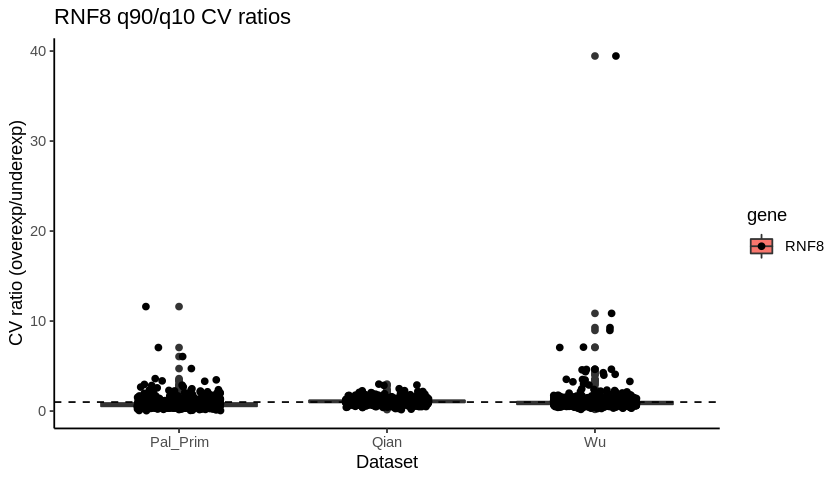

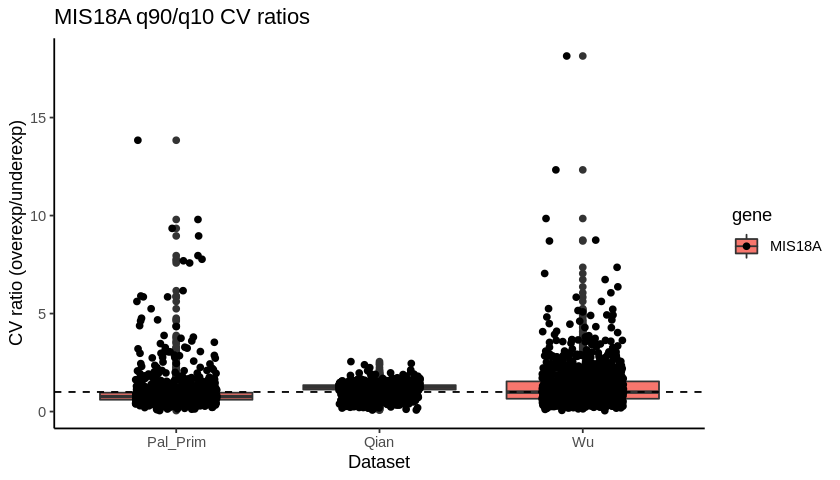

In [20]:
## lets plot the CV ratios
options(repr.plot.width = 7, repr.plot.height = 4)
df %>% filter(gene == 'RNF8') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('RNF8 q90/q10 CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')
df %>% filter(gene == 'MIS18A') %>% ggplot(aes(x = Dataset, y = CV_over_under_exp_ratio, fill = gene)) + geom_boxplot() + geom_jitter(width = 0.2) + theme_classic() + ylab('CV ratio (overexp/underexp)') + xlab('Dataset') + ggtitle('MIS18A q90/q10 CV ratios') + geom_hline(yintercept = 1, linetype = 'dashed')

In [ ]:
## s.genes <- cc.genes$s.genes
## g2m.genes <- cc.genes$g2m.genes
## bc_atlas_with_cc_scores <- CellCycleScoring(bc_atlas, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)